# The Power of Dividend Reinvestment with APIs, CSV and Montecarlo Simulations

Microsoft and Bitcoin will be used in this analysis. 
Gather historical data over 5 year period of time using one stock (MSFT) and one crypto currencies(BTC).
 
We will provide 3 different scenarios: 
1. Dividend reinvested in MSFT over 10, 20 and 30 Year period.
2. Dividend reinvested in Bitcoin over 10, 20 and 30 Year period.
3. Dividend not reinvested. 

we will use the information from the Monte Carlo simulation to answer questions about the portfolio.

In [166]:
# Import the required libraries and dependencies
import os
from pathlib import Path
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import hvplot.pandas
from MCForecastTools import MCSimulation

%matplotlib inline

In [167]:
# Load the environment variables from the .env file
# by calling the load_dotenv function
load_dotenv()

True

## Evaluate the Stock Holdings by Using the Alpaca SDK

In this section, we will determine the current value of the chosen stock holdings. We will make an API call to Alpaca via the Alpaca SDK to get the current closing prices of Microsoft (ticker: MSFT). For the prototype, assume that we hold 300 shares of MSFT, which represents the stock portfolio.

1. Create an environment file (`.env`) to store the values of your Alpaca API key and Alpaca secret key.

2. Set the variables for the Alpaca API and secret keys. Using the Alpaca SDK, create the Alpaca `tradeapi.REST` object. In this object, include the parameters for the Alpaca API key, the secret key, and the version number.

3. Set the following parameters for the Alpaca API call:

    - `tickers`: Use the tickers for Microsof.

    - `timeframe`: Use a time frame of one day.

    - `start_date` and `end_date`: Use the same date for these parameters, and format them with the date of the previous weekday. This is because you want the one closing price for the most-recent trading day.

4. Get the current closing prices for `MSFT` by using the Alpaca `get_barset` function. Format the response as a Pandas DataFrame by including the `df` property at the end of the `get_barset` function.

5. Navigating the Alpaca response DataFrame, select the `MSFT` closing prices, and store as variables.

6. Calculate the value, in US dollars, of the current amount of shares of the stock portfolio, and print the results.


Review the total number of shares held in our starting portfolio (SPY)

In [168]:
# Current amount of shares held in the stock (MSFT) portfolio.
msft_shares = 300 

#### 1: Create an environment file (`.env`) to store the values of your Alpaca API key and Alpaca secret key.

#### 2. Set the variables for the Alpaca API and secret keys. Using the Alpaca SDK, create the Alpaca `tradeapi.REST` object. In this object, include the parameters for the Alpaca API key, the secret key, and the version number.

In [169]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [170]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

#### 3: Set the following parameters for the Alpaca API call:

- `tickers`: Use the tickers for the member’s stock and bond holdings.

- `timeframe`: Use a time frame of one day.

- `start_date` and `end_date`: Use the same date for these parameters, and format them with the date of the previous weekday. This is because you want the one closing price for the most-recent trading day.

In [171]:
# Set the tickers
tickers = ["MSFT"]

In [172]:
# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"

In [173]:
# Format current date as ISO format
start_date = pd.Timestamp("2021-10-29", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-10-29", tz="America/New_York").isoformat()

#### 4: Get the current closing prices for `MSFT` by using the Alpaca `get_barset` function. Format the response as a Pandas DataFrame by including the `df` property at the end of the `get_barset` function.

In [174]:
# Use the Alpaca get_barset function to get current closing prices the portfolio
current_msft_price_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Review the first 5 rows of the Alpaca DataFrame
current_msft_price_df.head()

MSFT                              
                             open high    low   close    volume
time                                                           
2021-10-29 00:00:00-04:00  324.14  332  323.9  331.64  26504382

#### 5: Navigating the Alpaca response DataFrame, select the `MSFT` closing prices, and store them as variables.

In [175]:
# Access the closing price for MSFT from the Alpaca DataFrame
# Converting the value to a floating point number
msft_close_price = float(current_msft_price_df["MSFT"]["close"])

# Print the MSFT closing price
print(msft_close_price)

331.64


#### 6: Calculate the value, in US dollars, of the current amount of shares of the stock portfolio, and print the results.

In [176]:
# Calculate the current value of the portfolio
msft_value = round(msft_shares * msft_close_price, 3)

# Print the current value of the bond portfolio
print(f"The portofolio has a value of: {msft_value}")


The portofolio has a value of: 99492.0


## Use the `read_csv` function and the `Path` module to read the `msft_dividends.csv` file into a Pandas DataFrame.  Review the first five rows of the DataFrame by using the `head` function.

In [177]:
# Import the data by reading in the CSV file
# Review the first 5 rows of the DataFrame
msft_div = pd.read_csv(Path("Resources/msft_dividends.csv"))

msft_div.head()

,Announced,Period,Amount,Yield,Ex-Dividend,Record Date,Payable Date
0,9/14/2021,quarterly,$0.62,0.83%,11/17/2021,11/18/2021,12/9/2021
1,6/16/2021,quarterly,$0.56,0.87%,8/18/2021,8/19/2021,9/9/2021
2,3/16/2021,quarterly,$0.56,0.94%,5/19/2021,5/20/2021,6/10/2021
3,12/2/2020,quarterly,$0.56,1.04%,2/17/2021,2/18/2021,3/11/2021
4,9/15/2020,quarterly,$0.56,1.07%,11/18/2020,11/19/2020,12/10/2020


#### Use the `str.replace` function to remove the dollar signs ($) from the values in the Amount column.

In [180]:
# Use the str.replace function to remove the percent sign, %
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].str.replace("%", "")

#### Convert the data type of the column to a `float`.

In [181]:
# Convert the data type to a float
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].astype("float")

msft_div.dtypes

Announced        object
Period           object
Amount           object
Yield           float64
Ex-Dividend      object
Record Date      object
Payable Date     object
dtype: object

#### Choose columns of data on which to focus our analysis.

Select the data to analyze. Use `loc` to select the following columns of data:
* Yield

In [183]:
# Use loc to select `Yield` from the DataFrame
msft_div_slices = msft_div.loc[:, "Yield"]

# Review the first five rows of the DataFrame
msft_div_slices.head()

0    0.83
1    0.87
2    0.94
3    1.04
4    1.07
Name: Yield, dtype: float64

#### Calculating the average yearly % dividends for MSFT

In [185]:
# Calculating the average yearly % dividend for MSFT
msft_div_slices_average = round(msft_div_slices.mean(),2)

print(f"The average yearly dividend for Microsoft is: {average_year_div_msft}%.")

The average yearly dividend for Microsoft is: $1.84 per share.


### Evaluate the Bitcoin Value by Using the Requests Library

In this section, we will collect the current prices for the Bitcoin cryptocurrencies by using the Python Requests library. To do all this, complete the following steps:

1. Use the Requests library to get the current price (in US dollars) of Bitcoin (BTC) by using the API endpoints.

2. Navigate the JSON response object to access the current price of Bitcoin, and store it in a variable.


#### Review the endpoint URLs for the API calls to Free Crypto API in order to get the current pricing information for BTC.

In [141]:
# The Free Crypto API Call endpoint URLs for the held cryptocurrency assets
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"

#### 1. Use the Requests library to get the current price (in US dollars) of Bitcoin (BTC) by using the API endpoints.

In [142]:
# Using the Python requests library, make an API call to access the current price of BTC
btc_response = requests.get(btc_url).json()

# Use the json.dumps function to review the response data from the API call
# Use the indent and sort_keys parameters to make the response object readable
print(json.dumps(btc_response, indent=4, sort_keys=True))

{
    "data": {
        "1": {
            "circulating_supply": 18861862,
            "id": 1,
            "last_updated": 1635880109,
            "max_supply": 21000000,
            "name": "Bitcoin",
            "quotes": {
                "USD": {
                    "market_cap": 1193506334566,
                    "percent_change_1h": -0.180213483857481,
                    "percent_change_24h": 3.87629306140436,
                    "percent_change_7d": 0.106699306698335,
                    "percentage_change_1h": -0.180213483857481,
                    "percentage_change_24h": 3.87629306140436,
                    "percentage_change_7d": 0.106699306698335,
                    "price": 63296.0,
                    "volume_24h": 36228991531
                }
            },
            "rank": 1,
            "symbol": "BTC",
            "total_supply": 18861862,
            "website_slug": "bitcoin"
        }
    },
    "metadata": {
        "error": null,
        "num_cryptocurren

#### 2.Navigate the JSON response object to access the current price of Bitcoin, and store it in a variable.

In [143]:
# Navigate the BTC response object to access the current price of BTC
btc_price = btc_response['data']['1']['quotes']['USD']['price']

# Print the current price of BTC
print(f'The current price of BTC is ${btc_price:.2f}')

The current price of BTC is $63296.00


## Option 1: Reinvesting the dividens into Microsoft (MSFT) 

### Create the Monte Carlo Simulation that will include reinstment of dividend on a yearly basis

In this section, we will use the MCForecastTools library to create a Monte Carlo simulation for the purpose of reinvesting the dividend into the stock. 

1. Make an API call via the Alpaca SDK to get 5 years of historical closing prices for Microsft (MSFT).

2. Run a Monte Carlo simulations of 1000 samples for 10, 20 and 30 years for the portfolio, and then plot the results. 

3. Plot the probability distribution of the Monte Carlo simulations. Plot the probability distribution of the Monte Carlo simulation.

4. Generate the summary statistics for the Monte Carlo simulation.


In [144]:
# impoprt New version of the Montecarlo
from MCForecastTools_2Mod import MCSimulation

#### Step 1: Make an API call via the Alpaca SDK to get 5 years of historical closing prices for Microsoft.

In [145]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date 
start_date = pd.Timestamp("2016-10-29", tz="America/New_York").isoformat() 
end_date = pd.Timestamp("2021-10-29", tz="America/New_York").isoformat()

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [146]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set early of this activity 
# The start and end dates should be updated with the information set above
# Adding the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(tickers, timeframe, start= start_date, end= end_date, limit= limit_rows).df


# Display both the first and last five rows of the DataFrame
display(prices_df.head())
display(prices_df.tail())

MSFT                                
                            open    high    low  close    volume
time                                                            
2017-11-09 00:00:00-05:00  84.11  84.270  82.90  84.09  16833031
2017-11-10 00:00:00-05:00  83.79  84.095  83.23  83.86  13902816
2017-11-13 00:00:00-05:00  83.66  83.940  83.46  83.93   9097109
2017-11-14 00:00:00-05:00  83.50  84.100  82.98  84.05  15246771
2017-11-15 00:00:00-05:00  83.47  83.690  82.69  82.99  14184790

MSFT                                      
                             open      high       low   close    volume
time                                                                   
2021-10-25 00:00:00-04:00  309.54  309.5400  306.4600  308.30  13455241
2021-10-26 00:00:00-04:00  310.81  312.3950  308.5967  309.71  20748654
2021-10-27 00:00:00-04:00  316.00  326.0973  316.0000  323.14  45222243
2021-10-28 00:00:00-04:00  324.32  324.8700  321.3601  324.32  21324602
2021-10-29 00:00:00-04:00  324.14  332.0000  323.9000  331.64  26504382

#### Step 2a: Run a Monte Carlo simulation of 1000 samples and 10 years for Microsoft, and then plot the results.

In [147]:
# Configure the Monte Carlo simulation to forecast 10 years cumulative returns
# Run 1000 samples.
MC_ten_years = MCSimulation(portfolio_data = prices_df,
                             num_simulation= 1000,
                             num_trading_days= 252*10)

# Review the simulation input data
MC_ten_years.portfolio_data.head()


# We still need to update the Montecarlo first for this part!!! 

MSFT                                             
                            open    high    low  close    volume daily_return
time                                                                         
2017-11-09 00:00:00-05:00  84.11  84.270  82.90  84.09  16833031          NaN
2017-11-10 00:00:00-05:00  83.79  84.095  83.23  83.86  13902816    -0.002735
2017-11-13 00:00:00-05:00  83.66  83.940  83.46  83.93   9097109     0.000835
2017-11-14 00:00:00-05:00  83.50  84.100  82.98  84.05  15246771     0.001430
2017-11-15 00:00:00-05:00  83.47  83.690  82.69  82.99  14184790    -0.012612

In [148]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_years.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006884,1.040765,1.000732,0.981742,0.985437,1.020583,1.041405,0.978204,1.002500,0.973881,...,1.007582,1.036587,1.006404,1.029734,0.983788,1.014395,1.007583,0.980807,0.985389,0.967601
2,0.988896,1.049768,1.000075,1.002267,0.986668,1.030869,1.039858,0.960799,0.998573,0.989428,...,1.024457,1.040898,1.016838,1.020113,0.993963,1.007482,1.030102,0.958963,0.994032,0.987933
3,0.975727,1.045718,1.033872,1.019488,0.948261,1.048489,1.069679,0.951246,0.978144,0.967001,...,1.020916,1.031373,0.995454,1.012158,0.992905,1.002747,0.974315,0.972809,0.961438,0.983772
4,0.932377,1.022819,1.035877,1.029983,0.980517,1.040809,1.077233,0.958448,0.962745,0.965887,...,1.010876,1.047549,0.991763,1.003561,0.956303,1.017617,0.974238,0.977224,0.966302,0.986691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,32.166446,33.933750,23.689473,9.597337,34.530315,74.156043,17.437325,5.612450,11.947986,6.196738,...,17.395953,14.911275,31.301094,106.857420,131.057537,29.454436,31.694108,45.937168,48.252883,34.284760
2517,33.015321,32.570956,23.647783,9.529299,34.469026,73.694435,16.913549,5.578908,12.030887,6.190117,...,17.623082,14.756760,31.623948,104.342283,132.388667,29.113331,31.734451,45.669400,48.377306,34.623044
2518,32.904224,32.762474,23.595292,9.671726,34.501659,74.736417,16.871251,5.432670,12.309969,6.252236,...,18.419400,14.616484,32.073992,102.667559,132.953777,29.998162,31.515633,46.576732,48.848100,33.688203
2519,33.565866,33.482437,23.175866,9.562773,34.711464,73.336328,16.791547,5.419731,12.077419,6.042487,...,18.920628,14.670031,32.812040,102.291319,132.991129,30.941073,31.517057,46.389649,49.200413,33.712995


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

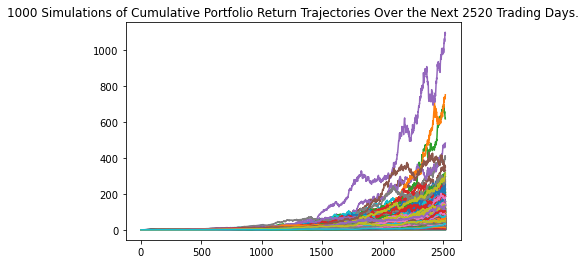

In [149]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_ten_years.plot_simulation()


#### Plot the probability distribution of the Monte Carlo simulation.

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

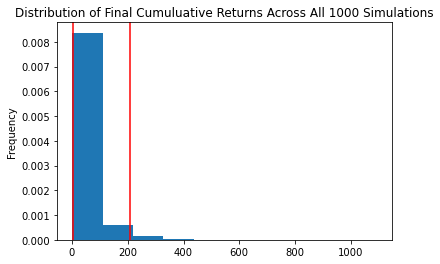

In [151]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
MC_ten_years.plot_distribution()

#### Generate the summary statistics for the Monte Carlo simulation.

In [152]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_ten_summary_statistics = round(MC_ten_years.summarize_cumulative_return(), 3)


# Review the 10-year Monte Carlo summary statistics
print(MC_ten_summary_statistics)

count           1000.000
mean              49.211
std               67.587
min                0.827
25%               17.077
50%               30.775
75%               55.660
max             1091.926
95% CI Lower       5.371
95% CI Upper     208.674
Name: 2520, dtype: float64


### Analyze the Dividend Reinvestment Into Microsoft Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?


In [153]:
# Print the current value of the stock.
print(f"The current value of the stock portfolio is: ${msft_value}")


The current value of the stock portfolio is: $99492.0


In [154]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the portfolio
ci_lower_ten_cumulative_return = MC_ten_summary_statistics[8] * msft_value
ci_upper_ten_cumulative_return = MC_ten_summary_statistics[9] * msft_value

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio and the reinvested deividend over the next 10 years will end within in range of \n"
     f"${ci_lower_ten_cumulative_return: .2f} and ${ci_upper_ten_cumulative_return: .2f}")


There is a 95% chance that you current protfolio over the next 30 years will end within in range of 
$ 534371.53 and $ 20761393.61


#### Step 2b: Run a Monte Carlo simulation of 1000 samples and 20 years for Microsoft, and then plot the results.

In [155]:
# Configure the Monte Carlo simulation to forecast 20 years cumulative returns
# Run 1000 samples.
MC_twenty_years = MCSimulation(portfolio_data = prices_df,
                             num_simulation= 1000,
                             num_trading_days= 252*20)

# Review the simulation input data
MC_twenty_years.portfolio_data.head()


# We need to update the Montecarlo first for this part!!! 

MSFT                                             
                            open    high    low  close    volume daily_return
time                                                                         
2017-11-09 00:00:00-05:00  84.11  84.270  82.90  84.09  16833031          NaN
2017-11-10 00:00:00-05:00  83.79  84.095  83.23  83.86  13902816    -0.002735
2017-11-13 00:00:00-05:00  83.66  83.940  83.46  83.93   9097109     0.000835
2017-11-14 00:00:00-05:00  83.50  84.100  82.98  84.05  15246771     0.001430
2017-11-15 00:00:00-05:00  83.47  83.690  82.69  82.99  14184790    -0.012612

In [156]:
# Run the Monte Carlo simulation to forecast 20 years cumulative returns
MC_twenty_years.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.975920,1.001516,1.022538,1.007904,1.008955,1.021343,0.996460,0.977719,0.994554,0.996430,...,0.989092,1.006123,1.005169,0.984516,1.023349,1.004237,1.009993,0.995444,1.035497,0.994723
2,0.980016,0.996084,1.027424,1.010112,0.994881,1.015282,0.976494,0.996261,0.990879,1.004351,...,0.964746,1.024540,0.995672,1.011427,1.015220,0.962197,1.027337,0.978170,1.005199,0.987762
3,0.994850,0.979420,1.037314,0.985334,0.989455,1.034651,0.986929,1.005175,1.021754,0.969361,...,0.968533,1.011461,0.954943,1.036377,1.043423,0.979650,1.077961,0.985115,1.005366,0.995181
4,0.997896,0.963503,1.017865,1.021823,0.989386,1.057163,0.974599,1.014983,1.046481,0.977793,...,0.973158,1.022841,0.950036,1.017466,1.039839,0.950362,1.104263,0.982671,1.021052,0.975594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,974.989343,1900.137025,1809.149676,223.949976,650.310979,3261.226457,2588.824856,150.147735,3512.329137,1523.149617,...,164.960763,417.364528,532.843738,4076.173927,339.978336,375.465322,917.662095,1678.237133,2721.377923,1801.583224
5037,967.007088,1946.382690,1843.844688,224.770782,651.609289,3286.418476,2582.176694,147.415104,3430.827083,1574.273713,...,163.030089,407.382166,524.103432,4176.861750,343.991696,373.775232,926.587734,1752.594046,2761.961944,1777.664853
5038,990.664308,1972.548622,1804.527945,220.096324,649.601167,3357.147684,2616.041650,150.425457,3479.694535,1601.164690,...,158.064368,415.229806,530.424531,4120.728976,352.760440,372.206864,954.904329,1759.298379,2745.917912,1747.058072
5039,965.261147,1998.096360,1771.157839,213.788618,635.014281,3454.600167,2631.944549,150.461250,3486.641387,1676.667968,...,158.197675,415.966222,532.489402,4092.235612,358.487071,370.913700,964.066539,1772.912839,2688.156539,1744.515865


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 5040 Trading Days.'}>

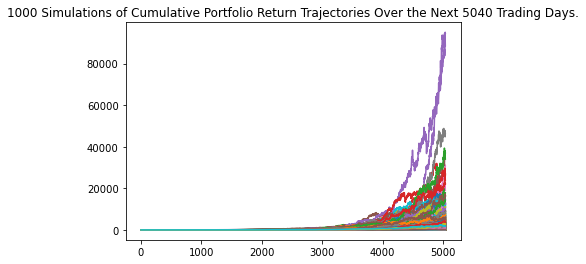

In [157]:
# Visualize the 20-year Monte Carlo simulation by creating an
# overlay line plot
MC_twenty_years.plot_simulation()


#### Plot the probability distribution of the Monte Carlo simulation.

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

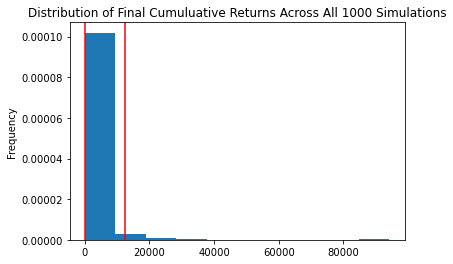

In [159]:
# Visualize the probability distribution of the 20-year Monte Carlo simulation 
# by plotting a histogram
MC_twenty_years.plot_distribution()

#### Generate the summary statistics for the Monte Carlo simulation.

In [160]:
# Generate summary statistics from the 20-year Monte Carlo simulation results
# Save the results as a variable
MC_twenty_summary_statistics = round(MC_twenty_years.summarize_cumulative_return(), 3)


# Review the 20-year Monte Carlo summary statistics
print(MC_twenty_summary_statistics)

count            1000.000
mean             2469.295
std              5567.959
min                15.820
25%               457.529
50%              1054.030
75%              2543.281
max             94226.485
95% CI Lower       86.605
95% CI Upper    12381.035
Name: 5040, dtype: float64


### Analyze the Dividend Reinvestment Into Microsoft Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [161]:
# Print the current value of the stock.
print(f"The current value of the stock portfolio is: ${msft_value}")


The current value of the stock portfolio is: $99492.0


In [162]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the portfolio
ci_lower_twenty_cumulative_return = MC_twenty_summary_statistics[8] * msft_value
ci_upper_twenty_cumulative_return = MC_twenty_summary_statistics[9] * msft_value

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio and the reinvested deividend over the next 20 years will end within in range of \n"
     f"${ci_lower_twenty_cumulative_return: .2f} and ${ci_upper_twenty_cumulative_return: .2f}")


There is a 95% chance that you current protfolio over the next 30 years will end within in range of 
$ 8616504.66 and $ 1231813934.22


#### Step 2c: Run a Monte Carlo simulation of 1000 samples and 30 years for Microsoft, and then plot the results.

In [ ]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# Run 1000 samples.
MC_thirty_years = MCSimulation(portfolio_data = prices_df,
                             num_simulation= 1000,
                             num_trading_days= 252*30)

# Review the simulation input data
MC_thirty_years.portfolio_data.head()


# We need to update the Montecarlo first for this part!!! 

In [ ]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_years.calc_cumulative_return()


In [ ]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
MC_thirty_years.plot_simulation()


#### Plot the probability distribution of the Monte Carlo simulation.

In [ ]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
MC_thirty_years.plot_distribution()

#### Generate the summary statistics for the Monte Carlo simulation.

In [ ]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_thirty_summary_statistics = round(MC_thirty_years.summarize_cumulative_return(), 3)


# Review the 30-year Monte Carlo summary statistics
print(MC_thirty_summary_statistics)

### Analyze the Dividend Reinvestment Into Microsoft Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [ ]:
# Print the current value of the stock.
print(f"The current value of the stock portfolio is: ${msft_value}")


In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the portfolio
ci_lower_thirty_cumulative_return = MC_thirty_summary_statistics[8] * msft_value
ci_upper_thirty_cumulative_return = MC_thirty_summary_statistics[9] * msft_value

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio and the reinvested deividend over the next 30 years will end within in range of \n"
     f"${ci_lower_thirty_cumulative_return: .2f} and ${ci_upper_thirty_cumulative_return: .2f}")


## Option 2: Reinvesting the dividens into Bitcoin Cryptocurrency (BTC) 

### Create the Monte Carlo Simulation that will include reinstment of dividend on a yearly basis

In this section, we will use the MCForecastTools library to create a Monte Carlo simulation for the purpose of reinvesting the dividend into the chosen crypto. 

1. Using read_csv, get the historical closing prices for Bitcoin (BTC).

2. Run a Monte Carlo simulations of 1000 samples for 10, 20 and 30 years for the portfolio, and then plot the results. 

3. Plot the probability distribution of the Monte Carlo simulations. Plot the probability distribution of the Monte Carlo simulation.

4. Generate the summary statistics for the Monte Carlo simulation.


## Option 3: Keep the dividens as cash and see where Microsoft (MSFT) could be without reinvesting

### Create the Monte Carlo Simulation that will include reinstment of dividend on a yearly basis

In this section, we will use the MCForecastTools library to create a Monte Carlo simulation for Microsoft (MSFT)

1. Run a Monte Carlo simulations of 1000 samples for 10, 20 and 30 years for the portfolio, and then plot the results. 

2. Plot the probability distribution of the Monte Carlo simulations. Plot the probability distribution of the Monte Carlo simulation.

3. Generate the summary statistics for the Monte Carlo simulation.


#### Step 1a: Run a Monte Carlo simulation of 1000 samples and 10 years for Microsoft, and then plot the results.

In [ ]:
# Configure the Monte Carlo simulation to forecast 10 years cumulative returns
# Run 1000 samples.
ten_year_simulation = MCSimulation(portfolio_data = prices_df,
                             num_simulation= 1000,
                             num_trading_days= 252*10)

# Review the simulation input data
ten_year_simulation.portfolio_data.head()

In [ ]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
ten_year_simulation.calc_cumulative_return()

In [ ]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
ten_year_simulation.plot_simulation()

#### Plot the probability distribution of the Monte Carlo simulation.

In [ ]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
ten_year_simulation.plot_distribution()


#### Generate the summary statistics for the Monte Carlo simulation.

In [ ]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
ten_tbl_summary_statistics = round(ten_year_simulation.summarize_cumulative_return(),2)


# Review the 10-year Monte Carlo summary statistics
print(ten_tbl_summary_statistics)

### Analyze Microsoft stock Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [ ]:
# Print the current value of the stock.
print(f"The current value of the stock portfolio is: ${msft_value}")

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = round(ten_tbl[8] * msft_value,2)
ci_upper_ten_cumulative_return = round(ten_tbl[9] * msft_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio over the next 10 years will end within in range of \n"
     f"${ci_lower_thirty_cumulative_return: .2f} and ${ci_upper_thirty_cumulative_return: .2f}")


#### Step 1b: Run a Monte Carlo simulation of 1000 samples and 20 years for Microsoft, and then plot the results.

In [ ]:
# Configure a Monte Carlo simulation to forecast 20 years cumulative returns
# Run 1000 samples
twenty_year_simulation = MCSimulation(portfolio_data= prices_df,
                                      num_simulation=1000,
                                      num_trading_days=252*20,)

# Review the simulation input data
twenty_year_simulation.portfolio_data.head()

In [ ]:
# Run the Monte Carlo simulation to forecast 20 years cumulative returns
twenty_year_simulation.calc_cumulative_return()

In [ ]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
twenty_year_simulation.plot_simulation()

#### Plot the probability distribution of the Monte Carlo simulation.

In [ ]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
twenty_year_simulation.plot_distribution()


#### Generate the summary statistics for the Monte Carlo simulation.

In [ ]:
# Generate summary statistics from the 20-year Monte Carlo simulation results
# Save the results as a variable
twenty_tbl= round(twenty_year_simulation.summarize_cumulative_return(), 2)


# Review the 10-year Monte Carlo summary statistics
print(twenty_tbl)

### Analyze Microsoft stock Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [ ]:
# Print the current balance of the MSFT portfolio
print(f'The current balance of the MSFT portfolio is: ${msft_value:.2f}')

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_twenty_cumulative_return = round(twenty_tbl[8] * msft_value,2)
ci_upper_twenty_cumulative_return = round(twenty_tbl[9] * msft_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio over the next 20 years will end within in range of \n"
     f"${ci_lower_thirty_cumulative_return: .2f} and ${ci_upper_thirty_cumulative_return: .2f}")

#### Step 1c: Run a Monte Carlo simulation of 1000 samples and 30 years for Microsoft, and then plot the results.

In [ ]:
# Configure a Monte Carlo simulation to forecast 30 years cumulative returns
# Run 1000 samples
thirty_year_simulation = MCSimulation(portfolio_data = prices_df,
                                      num_simulation = 1000,
                                      num_trading_days = 252 * 30,)

# Review the simulation input data
thirty_year_simulation.portfolio_data.head()

In [ ]:
# Run the Monte Carlo simulation to forecast 30 years cumulative returns
thirty_year_simulation.calc_cumulative_return()

In [ ]:
### Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
thirty_year_simulation.plot_simulation()

#### Plot the probability distribution of the Monte Carlo simulation.

In [ ]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
thirty_year_simulation.plot_distribution()

#### Generate the summary statistics for the Monte Carlo simulation.

In [ ]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
thirty_tbl=thirty_year_simulation.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
thirty_tbl

### Analyze Microsoft stock Portfolio Forecasts

Using the current value of the stock portfolio and the summary statistics that was generated from the Monte Carlo simulation, let's see what are the lower and upper bounds for the expected value of the portfolio with a 95% confidence interval?

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_thirty_cumulative_return = round(thirty_tbl[8] * msft_value,2)
ci_upper_thirty_cumulative_return = round(thirty_tbl[9] * msft_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that you current protfolio over the next 30 years will end within in range of \n"
     f"${ci_lower_thirty_cumulative_return: .2f} and ${ci_upper_thirty_cumulative_return: .2f}")